# Aries Basic Controller - Sovrin Stagingnet Issuer Agent

## This notebook walks through how to issue a credential across a newly established connection with a mobile SSI agent. 

## Before running through this notebook you should run through the following notebook - [Part 2](http://localhost:8888/notebooks/Part%202%20-%20Writing%20a%20Public%20DID%20to%20the%20Sovrin%20StagingNet.ipynb).

If unfamiliar with the protocol it is worth reading through the [aries-rfs](https://github.com/hyperledger/aries-rfcs/tree/master/features/0036-issue-credential)


## 1. Initialise a controller for the GMC

In [4]:
%autoawait
import time
import asyncio
from termcolor import colored,cprint

from aries_basic_controller.aries_controller import AriesAgentController
    
WEBHOOK_HOST = "0.0.0.0"
WEBHOOK_PORT = 8032
WEBHOOK_BASE = ""
ADMIN_URL = "http://gmc-agent:8031"

# Based on the aca-py agent you wish to control
agent_controller = AriesAgentController(webhook_host=WEBHOOK_HOST, webhook_port=WEBHOOK_PORT,
                                       webhook_base=WEBHOOK_BASE, admin_url=ADMIN_URL)
    

IPython autoawait is `on`, and set to use `asyncio`


## 2. Register Listeners

The handler should get called every time the controller receives a webhook with the topic issue_credential, printing out the payload. The agent calls to this webhook every time it receives an issue-credential protocol message from a credential.

In [5]:
loop = asyncio.get_event_loop()
loop.create_task(agent_controller.listen_webhooks())

def cred_handler(payload):
    print("Handle Credentials")
    exchange_id = payload['credential_exchange_id']
    state = payload['state']
    role = payload['role']
    attributes = payload['credential_proposal_dict']['credential_proposal']['attributes']
    print(f"Credential exchange {exchange_id}, role: {role}, state: {state}")
    print(f"Offering: {attributes}")
    
cred_listener = {
    "topic": "issue_credential",
    "handler": cred_handler
}

def connections_handler(payload):
    global STATE
    connection_id = payload["connection_id"]
    print("Connection message", payload, connection_id)
    STATE = payload['state']
    if STATE == 'active':
#         print('Connection {0} changed state to active'.format(connection_id))
        print(colored("Connection {0} changed state to active".format(connection_id), "red", attrs=["bold"]))


connection_listener = {
    "handler": connections_handler,
    "topic": "connections"
}

agent_controller.register_listeners([cred_listener,connection_listener], defaults=True)


Task exception was never retrieved
future: <Task finished coro=<AriesAgentController.listen_webhooks() done, defined at /aries_basic_controller/aries_controller.py:77> exception=OSError(98, "error while attempting to bind on address ('0.0.0.0', 8032): address already in use")>
Traceback (most recent call last):
  File "/aries_basic_controller/aries_controller.py", line 83, in listen_webhooks
    await self.webhook_site.start()
  File "/opt/conda/lib/python3.7/site-packages/aiohttp/web_runner.py", line 104, in start
    reuse_port=self._reuse_port)
  File "/opt/conda/lib/python3.7/asyncio/base_events.py", line 1385, in create_server
    % (sa, err.strerror.lower())) from None
OSError: [Errno 98] error while attempting to bind on address ('0.0.0.0', 8032): address already in use


## 3a. Use a previously written schema

In [3]:
schema_id = '2yWoMSfeTtYBFpUJFcnpqL:2:GMC Registration:0.0.1'

## 3b. (OPTIONAL) Write a Schema to the Ledger

For more details see the [schema-api notebook](http://localhost:8888/notebooks/schema_api.ipynb)

**Note: You will only be able to do this once unless you change the schema_name or version. Once you have a schema written to the ledger it can be reused by multiple entities**

In [11]:
# Define you schema name - must be unique on the ledger
schema_name = "GMC Registration"
# Can version the schema if you wish to update it
schema_version = "0.0.1"
# Define any list of attributes you wish to include in your schema
attributes = [ "GMC Reference Number",
     "GMC Given Name",
     "GMC Surname",
     "GMC Gender",
     "GMC Reg Status",
     "GMC FTP Status",
     "GMC Primary Medical Qual",
     "GMC Prov Reg Date",
     "GMC Full Reg Date",
     "GMC Spec. Register Status",
     "GMC Primary Specialty",
     "GMC GP Register Status",
     "GMC GP Register Date",
     "GMC Revalidation Status",
     "GMC Training Information",
     "GMC Designated Body",
     "GMC Responsible Office"]

response = await agent_controller.schema.write_schema(schema_name, attributes, schema_version)
schema_id = response["schema_id"]
print(schema_id)


CwAzbuCFhpKzmrvyfXnVzH:2:GMC Registration:0.0.1


## 4. Credential Definition created previously

**Note: Again this can only be done once per issuer, per schema_id.**

In [1]:
%store -r cred_def
cred_def_id = cred_def

no stored variable or alias cred_def


NameError: name 'cred_def' is not defined

**Note: You should be able to see both schema and definition transactions on Sovrin Stagingnet network with [Indyscan](https://indyscan.io/home/SOVRIN_STAGINGNET)**

## 5. Populate the Attribues to Issue to Idenity Holder (User)

We will issue a credential to the identity holder consisting of the following attributes:

credential_attributes = [
    {"name": "fullname", "value": name},
    {"name": "skill", "value": "PyDentity SSI Ninja"},
    {"name": "age", "value": age}
]

The notebook will ask you to input the identity holder's full name and age which will be used to populate the schema above with the identity holders attribute information.

In [7]:
reference_number=input("Please enter your reference number: ")
name=input("Please enter your name ")
surname = input("Please enter your surname")
gender = input("Please enter your gender")
# reg_status = input("Please enter your reg_status")
# ftp_status = input("Please enter your FTP status")
# medical_qual = input("Please enter your primary medical qualification")
# prov_reg_date =("Please enter your provisional registration date")
# full_reg_date =("Please enter your full reg date")
# spec_register_status =("Please enter your Spec. register status")
# primary_speciality =("Please enter your primary speciality")
# gp_register_status =("Please enter your gp register status")
# gp_register_date =("Please enter your gp register date")
# revalidation_status =("Please enter your revalidation status")
# training_information =("Please enter your training information")
# designated_body =("Please enter your designated body")
# responsible_officer =("Please enter your Responsible Officer")
credential_attributes = [
    {"name": "GMC Reference Number", "value": reference_number},
    {"name": "GMC Given Name", "value": name},
    {"name": "GMC Surname", "value": surname},
    {"name":"GMC Gender", "value": gender},
    {"name":"GMC Reg Status", "value": "Active"},
    {"name":"GMC FTP Status", "value": "Active"},
    {"name":"GMC Primary Medical Qual", "value":"Paediatrition"},
    {"name":"GMC Prov Reg Date", "value":"00/00/00"},
    {"name":"GMC Full Reg Date", "value":"00/00/00"},
    {"name":"GMC Spec. Register Status", "value":"Active"},
    {"name":"GMC Primary Specialty", "value":"Paediatrics"},
    {"name":"GMC GP Register Status", "value":"Active"},
    {"name":"GMC GP Register Date", "value":"00/00/00"},
    {"name":"GMC Revalidation Status", "value":"Active"},
    {"name":"GMC Training Information", "value":"Stage 1"},
    {"name":"GMC Designated Body", "value":"NHS"},
    {"name":"GMC Responsible Officer", "value":"Head Doctor"}
    
    
]
print(credential_attributes)

Please enter your reference number: 2334
Please enter your name VIneeth
Please enter your surnameR
Please enter your genderM
[{'name': 'GMC Reference Number', 'value': '2334'}, {'name': 'GMC Given Name', 'value': 'VIneeth'}, {'name': 'GMC Surname', 'value': 'R'}, {'name': 'GMC Gender', 'value': 'M'}, {'name': 'GMC Reg Status', 'value': 'Active'}, {'name': 'GMC FTP Status', 'value': 'Active'}, {'name': 'GMC Primary Medical Qual', 'value': 'Paediatrition'}, {'name': 'GMC Prov Reg Date', 'value': '00/00/00'}, {'name': 'GMC Full Reg Date', 'value': '00/00/00'}, {'name': 'GMC Spec. Register Status', 'value': 'Active'}, {'name': 'GMC Primary Specialty', 'value': 'Paediatrics'}, {'name': 'GMC GP Register Status', 'value': 'Active'}, {'name': 'GMC GP Register Date', 'value': '00/00/00'}, {'name': 'GMC Revalidation Status', 'value': 'Active'}, {'name': 'GMC Training Information', 'value': 'Stage 1'}, {'name': 'GMC Designated Body', 'value': 'NHS'}, {'name': 'GMC Responsible Officer', 'value': '

## 7. Download Identity Holder Mobile SSI Wallet
Please download a mobile SSI wallet such as [Connect.me](https://connect.me/), [Trinsic](https://trinsic.id/trinsic-wallet/) or any other Aries compatible wallet.

## 8. Create a connection invitation to scan with the Mobile SSI Wallet

To make a connection with an identity holders wallet we must create a connection invitation and present the QR code to be scanned by the identity holders wallet. The identity holder scan this QR code and then communicate back to the agent through the exposed ngrok endpoint.

Once a connection is in an active state, the agent and the identity holders mobile wallet now have a secure pairwise relationship over which they can exchange verifiable credentials.

## 8a. Check for any existing connections

In [8]:
# Check for existing connections
connection = await agent_controller.connections.get_connections()
print("EXISTING CONNECTIONS")
for key, value in connection.items():
    for item in value:
        print('ConnectionID:', item['connection_id'], 'Status:',item['state'])

EXISTING CONNECTIONS


## 8b. Create an Invitation

In [9]:
# Create Invitation
invite = await agent_controller.connections.create_invitation()
connection_id = invite["connection_id"]
print("Connection ID", connection_id)
print("Invitation")
print(invite['invitation_url'])
inviteURL = invite['invitation_url']

Connection message {'invitation_mode': 'once', 'routing_state': 'none', 'updated_at': '2020-09-21 15:48:23.192372Z', 'state': 'invitation', 'initiator': 'self', 'connection_id': '85899fb9-6dc1-4b54-bcd1-ad790588e817', 'accept': 'auto', 'invitation_key': '6hdPutKaHgSP7fdmbbF11sDd2DKy2p7qE6iPQGsVHXAx', 'created_at': '2020-09-21 15:48:23.192372Z'} 85899fb9-6dc1-4b54-bcd1-ad790588e817
Connection ID 85899fb9-6dc1-4b54-bcd1-ad790588e817
Invitation
https://ca4256742cf4.ngrok.io?c_i=eyJAdHlwZSI6ICJkaWQ6c292OkJ6Q2JzTlloTXJqSGlxWkRUVUFTSGc7c3BlYy9jb25uZWN0aW9ucy8xLjAvaW52aXRhdGlvbiIsICJAaWQiOiAiYWI3NTJmYjItN2YxMi00NzYwLTgwODEtNjFmMzFlODFiNjg3IiwgInJlY2lwaWVudEtleXMiOiBbIjZoZFB1dEthSGdTUDdmZG1iYkYxMXNEZDJES3kycDdxRTZpUFFHc1ZIWEF4Il0sICJsYWJlbCI6ICJNZWRpY2FsIFNjaG9vbCIsICJzZXJ2aWNlRW5kcG9pbnQiOiAiaHR0cHM6Ly9jYTQyNTY3NDJjZjQubmdyb2suaW8ifQ==


## 8c. Generate QR Code to be scanned with Mobile SSI Wallet

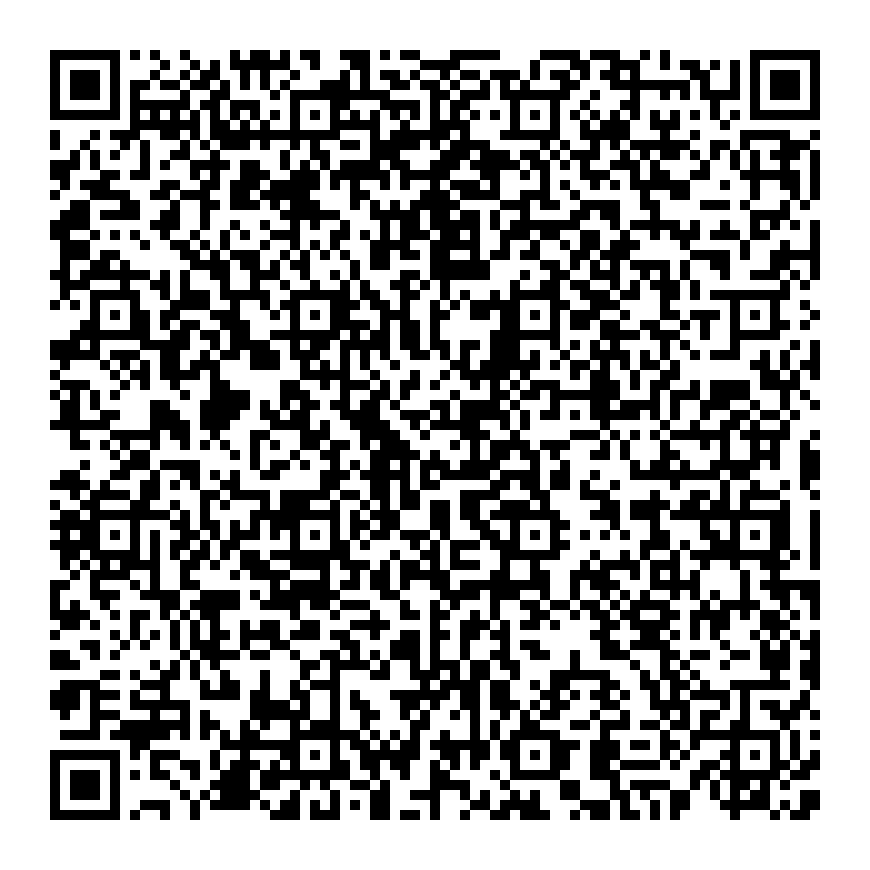

Connection message {'their_did': 'ULVnjmBr8LdChitZ7aVUNM', 'their_label': "Vineeth's Pixel 3", 'invitation_mode': 'once', 'routing_state': 'none', 'updated_at': '2020-09-21 15:48:37.933557Z', 'state': 'request', 'initiator': 'self', 'connection_id': '85899fb9-6dc1-4b54-bcd1-ad790588e817', 'accept': 'auto', 'invitation_key': '6hdPutKaHgSP7fdmbbF11sDd2DKy2p7qE6iPQGsVHXAx', 'created_at': '2020-09-21 15:48:23.192372Z'} 85899fb9-6dc1-4b54-bcd1-ad790588e817
Connection message {'their_did': 'ULVnjmBr8LdChitZ7aVUNM', 'their_label': "Vineeth's Pixel 3", 'invitation_mode': 'once', 'routing_state': 'none', 'updated_at': '2020-09-21 15:48:38.740085Z', 'state': 'response', 'initiator': 'self', 'connection_id': '85899fb9-6dc1-4b54-bcd1-ad790588e817', 'accept': 'auto', 'my_did': 'WCEFqEzPvXxUAbgnVG2YkQ', 'invitation_key': '6hdPutKaHgSP7fdmbbF11sDd2DKy2p7qE6iPQGsVHXAx', 'created_at': '2020-09-21 15:48:23.192372Z'} 85899fb9-6dc1-4b54-bcd1-ad790588e817


In [10]:
import qrcode
# Link for connection invitation
input_data = inviteURL
# Creating an instance of qrcode
qr = qrcode.QRCode(
        version=1,
        box_size=10,
        border=5)
qr.add_data(input_data)
qr.make(fit=True)
img = qr.make_image(fill='black', back_color='white')
img.save('issuer_agent_invite_QRcode.png')

from IPython.display import Image
Image(width=400, filename='./issuer_agent_invite_QRcode.png')

## 8d. Check if established connection is in active state

In [11]:
import time

# print('Current state for ConnectionId {} is {}'.format(connection_id,STATE))
print(colored("Current state for ConnectionId {} is {}".format(connection_id,STATE), "magenta", attrs=["bold"]))
while STATE != 'active':
#     print('ConnectionId {0} is not in active state yet'.format(connection_id))
    print(colored("ConnectionId {0} is not in active state yet".format(connection_id), "yellow", attrs=["bold"]))
    trust_ping = await agent_controller.messaging.trust_ping(connection_id,'hello!')
#     print('Trust ping send to ConnectionId {0} to activate connection'.format(trust_ping))
    print(colored("Trust ping send to ConnectionId {0} to activate connection".format(trust_ping), "blue", attrs=["bold"]))
    time.sleep(5)
    
# print('ConnectionId: {0} is now active. Continue with notebook'.format(connection_id))
print(colored("ConnectionId: {0} is now active. Continue with notebook".format(connection_id), "green", attrs=["bold"]))


Current state for ConnectionId 85899fb9-6dc1-4b54-bcd1-ad790588e817 is response
ConnectionId 85899fb9-6dc1-4b54-bcd1-ad790588e817 is not in active state yet
Trust ping send to ConnectionId {'thread_id': '40a3be2a-9096-4979-8adf-f2d4f91b38c7'} to activate connection
ConnectionId 85899fb9-6dc1-4b54-bcd1-ad790588e817 is not in active state yet
Connection message {'their_did': 'ULVnjmBr8LdChitZ7aVUNM', 'their_label': "Vineeth's Pixel 3", 'invitation_mode': 'once', 'routing_state': 'none', 'updated_at': '2020-09-21 15:48:44.395379Z', 'state': 'active', 'initiator': 'self', 'connection_id': '85899fb9-6dc1-4b54-bcd1-ad790588e817', 'accept': 'auto', 'my_did': 'WCEFqEzPvXxUAbgnVG2YkQ', 'invitation_key': '6hdPutKaHgSP7fdmbbF11sDd2DKy2p7qE6iPQGsVHXAx', 'created_at': '2020-09-21 15:48:23.192372Z'} 85899fb9-6dc1-4b54-bcd1-ad790588e817
Connection 85899fb9-6dc1-4b54-bcd1-ad790588e817 changed state to active
Trust ping send to ConnectionId {'thread_id': '6a881949-ef99-4fa5-ad99-6de97e1e63c9'} to activ

## 9. Send Credential

This sends a credential to a identity holder (User), and automates the rest of the protocol.

There are other ways to issue a credential that require multiple api calls.

**Arguments**
* connection_id: The connection_id of the holder you wish to issue to (MUST be in active state)
* schema_id: The id of the schema you wish to issue
* cred_def_id: The definition (public key) to sign the credential object. This must refer to the schema_id and be written to the ledger by the same public did that is currently being used by the agent.
* attributes: A list of attribute objects as defined above. Must match the schema attributes.
* comment (optional): Any string, defaults to ""
* auto_remove (optional): Boolean, defaults to True. I believe this removes the record of this credential once it has been issued. (TODO: double check)
* trace (optional): Boolean, defaults to False. **Not entirely sure about this one, believe its for logging. Also when set to True it throws an error**

In [12]:
record = await agent_controller.issuer.send_credential(connection_id, schema_id, cred_def_id, credential_attributes, trace=False)
record_id = record['credential_exchange_id']
state = record['state']
role = record['role']
print(f"Credential exchange {record_id}, role: {role}, state: {state}")


Handle Credentials
Credential exchange 7aa94eea-2978-459e-b868-1da07cd94113, role: issuer, state: offer_sent
Offering: [{'name': 'GMC Reference Number', 'value': '2334'}, {'name': 'GMC Given Name', 'value': 'VIneeth'}, {'name': 'GMC Surname', 'value': 'R'}, {'name': 'GMC Gender', 'value': 'M'}, {'name': 'GMC Reg Status', 'value': 'Active'}, {'name': 'GMC FTP Status', 'value': 'Active'}, {'name': 'GMC Primary Medical Qual', 'value': 'Paediatrition'}, {'name': 'GMC Prov Reg Date', 'value': '00/00/00'}, {'name': 'GMC Full Reg Date', 'value': '00/00/00'}, {'name': 'GMC Spec. Register Status', 'value': 'Active'}, {'name': 'GMC Primary Specialty', 'value': 'Paediatrics'}, {'name': 'GMC GP Register Status', 'value': 'Active'}, {'name': 'GMC GP Register Date', 'value': '00/00/00'}, {'name': 'GMC Revalidation Status', 'value': 'Active'}, {'name': 'GMC Training Information', 'value': 'Stage 1'}, {'name': 'GMC Designated Body', 'value': 'NHS'}, {'name': 'GMC Responsible Officer', 'value': 'Head D

## 10. Accept credential in Mobile SSI Wallet

## 11. End of Tutorial

Be sure to terminate the controller so you can run another tutorial.

In [18]:
response = await agent_controller.terminate()
print(response)

None


# Proceed to Part 4 on [Verifier Notebook](http://127.0.0.1:8889/notebooks/Part%204%20-%20Verifier.ipynb)

Here you will present the attributes issued to you within this tutorial to a verifying entity.